In [140]:
import csv
import random
import numpy
import pandas as pd
import math
import time
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# amino_acids = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'+"


In [141]:
# torch.set_default_tensor_type('torch.DoubleTensor')

In [142]:
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))

In [143]:
motifs = (numpy.genfromtxt('data/popular_new_motifs.csv',dtype='U'))
fams = (numpy.genfromtxt('data/popular_new_fams.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('data/popular_new_motifxFamMatrix.csv',delimiter=',',dtype=int)

# motifs = (numpy.genfromtxt('data/new_motifs.csv',dtype='U'))
# fams = (numpy.genfromtxt('data/new_fams.csv',dtype='U'))
# motifxFamMatrix = numpy.genfromtxt('data/new_motifxFamMatrix.csv',delimiter=',',dtype=int)

print (motifxFamMatrix.shape)

(8185, 23)


In [144]:
new_fams_idc = numpy.where([sum(x) > 400 for x in motifxFamMatrix.T])[0]
new_fams = fams[new_fams_idc]

new_motifs = []
new_fams_to_motifs = {f:[] for f in new_fams}

for fam_idx in new_fams_idc:
    motif_idc = numpy.where( motifxFamMatrix.T[fam_idx]==1 )[0]
    fam = fams[fam_idx]
    for idx in motif_idc:
        new_motifs.append(motifs[idx])
        new_fams_to_motifs[fam].append(motifs[idx])
new_motifs = list(set(new_motifs))

new_motifs = numpy.array((new_motifs))
new_fams = numpy.array((new_fams))

new_motifxFamMatrix = numpy.zeros((len(new_motifs),len(new_fams)))

for fIdx,fam_vec in enumerate(new_motifxFamMatrix.T):
    fam = new_fams[fIdx]
    for motif in new_fams_to_motifs[fam]:
        mIdx = numpy.where(new_motifs==motif)[0]
        fam_vec[mIdx] = 1

In [145]:
motifxFamMatrix = new_motifxFamMatrix
motifs = new_motifs
fams = new_fams

In [146]:
# df = pd.DataFrame(motifxFamMatrix,dtype=int)
# df.to_csv("very_popular_motifxFamMatrix.csv",header=None,index=None)

# df = pd.DataFrame(motifs,dtype='U')
# df.to_csv("very_popular_motifs.csv",header=None,index=None)

# df = pd.DataFrame(fams,dtype='U')
# df.to_csv("very_popular_fams.csv",header=None,index=None)

In [147]:
print (motifxFamMatrix.shape)
for fIdx,fam in enumerate(motifxFamMatrix.T):
    print (fams[fIdx],numpy.sum(motifxFamMatrix.T[fIdx]))

(6720, 13)
CK2 519.0
CAMKL 664.0
CK1 467.0
MAPK 1066.0
RSK 466.0
NEK 454.0
CDK 1267.0
DYRK 510.0
STE20 637.0
PIKK 420.0
PKC 859.0
PKA 796.0
Src 677.0


In [148]:
all_characters = []
for motif in motifs:
    for c in motif:
        all_characters.append(c)
print (len(set(all_characters)))
amino_acids = ''.join(list(set(all_characters)))
num_amino_acids = (len(set(all_characters)))

20


In [149]:
numOfMotifsPerFam = []
for fIdx,fam in enumerate(motifxFamMatrix.T):
    numOfMotifsPerFam.append([fams[fIdx],numpy.sum(motifxFamMatrix.T[fIdx])])
numOfMotifsPerFam.sort(key=lambda x:x[1], reverse=True)
numOfMotifsPerFam

[['CDK', 1267.0],
 ['MAPK', 1066.0],
 ['PKC', 859.0],
 ['PKA', 796.0],
 ['Src', 677.0],
 ['CAMKL', 664.0],
 ['STE20', 637.0],
 ['CK2', 519.0],
 ['DYRK', 510.0],
 ['CK1', 467.0],
 ['RSK', 466.0],
 ['NEK', 454.0],
 ['PIKK', 420.0]]

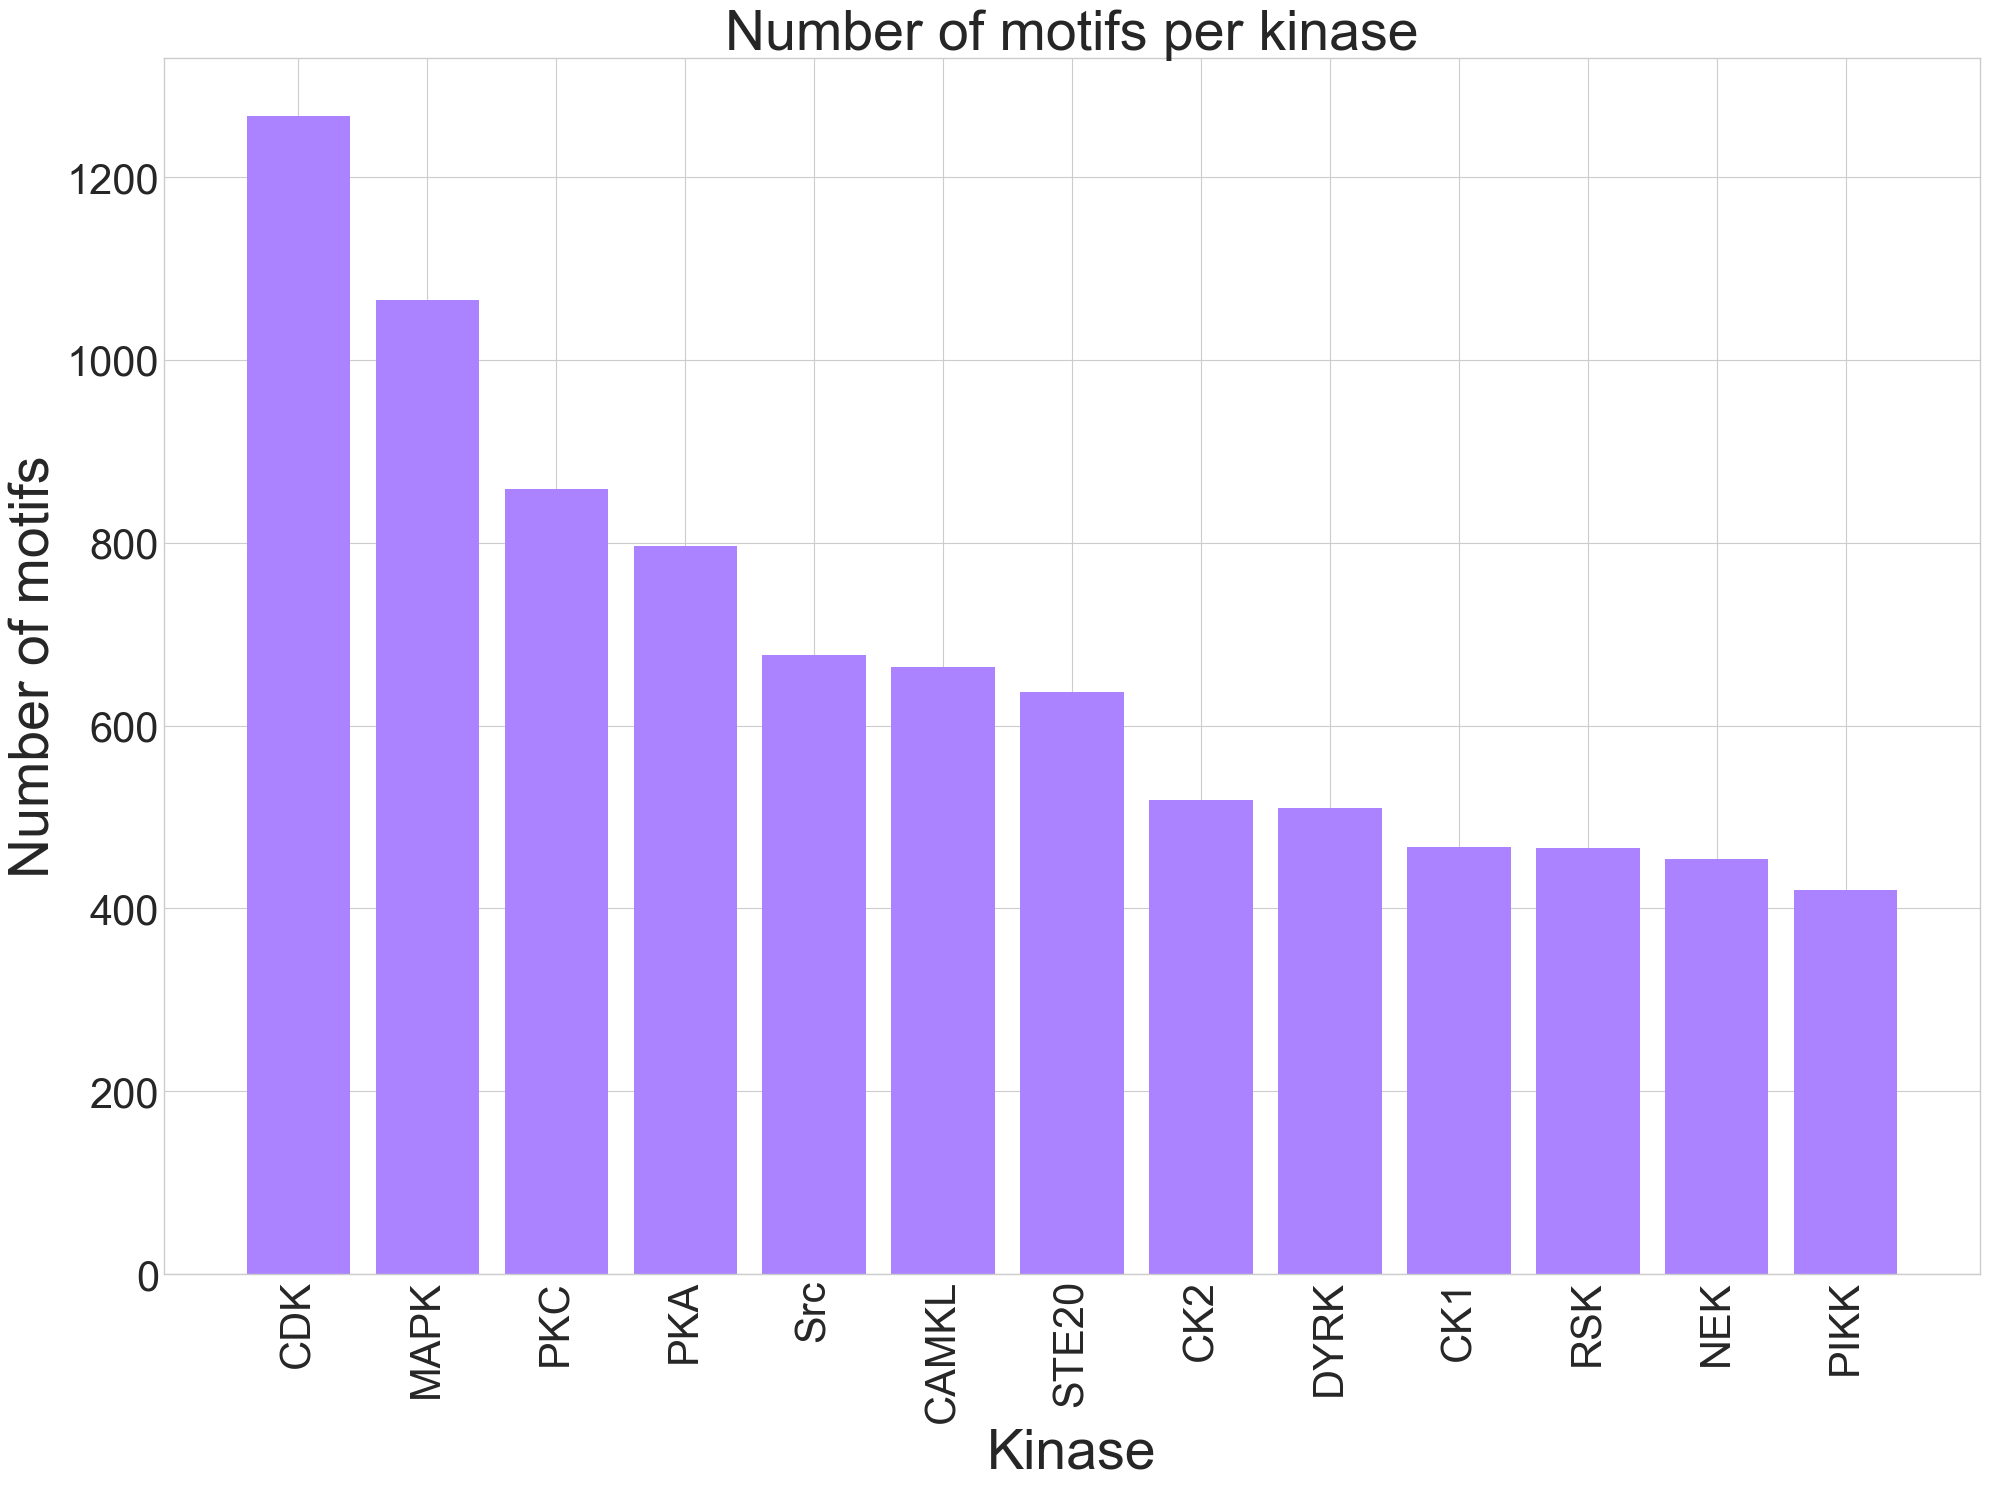

In [150]:
plt.style.use('seaborn-whitegrid')

index = numpy.arange(len(numOfMotifsPerFam))
plt.figure(figsize=(20,15))
plt.bar(index, [x[1] for x in numOfMotifsPerFam],color='#AB82FF')# 'tomato')
plt.xlabel('Kinase', fontsize=40)
plt.ylabel('Number of motifs', fontsize=40)
plt.xticks(index, [x[0] for x in numOfMotifsPerFam], fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.title('Number of motifs per kinase',fontsize=40)
plt.tight_layout()
plt.savefig("Distribution_of_motifs_2")
plt.show()

In [13]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, num_amino_acids)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, num_amino_acids)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def motifToStringTensor(motif):
    motif = [letterToIndex(x) for x in motif]
    motif = torch.tensor(motif).unsqueeze(1)
    return (motif)

def getMotifAndFamForTraining(mIdx):
    motif = motifs[mIdx]
    motif_tensor = motifToStringTensor(motif)  
    fIdx = numpy.where(motifxFamMatrix[mIdx]==1)[0][0]
    fam = fams[fIdx]
    fam_tensor = torch.tensor(fIdx.reshape(1))
    return motif_tensor, fam_tensor

In [17]:
random.seed(46)

idc = (numpy.arange(len(motifs)))
random.shuffle(idc)
trainAndTestSets = []

trainSetSize = int(len(motifs) * .8)
testSetSize = int(len(motifs) * .2)

for i in range(5):
    s = i * testSetSize
    e = i * testSetSize + testSetSize
    testIdc = idc[s:e]
    
    trainIdc = [x for x in idc if x not in testIdc] 
    trainAndTestSets.append( [trainIdc,testIdc] )
    
print (len(trainAndTestSets[4][0]))
print (len(trainAndTestSets[4][1]))

5376
1344


In [18]:
import torch
import torch.nn as nn

HIDDEN_DIM_1 = 25
HIDDEN_DIM_3 = 15

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.lstm = nn.LSTM(num_amino_acids, HIDDEN_DIM_1, num_layers=1, bidirectional=True)
        self.hidden1 = nn.Linear(HIDDEN_DIM_1 * 2, len(fams))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sentence, maxLen): 
        lstm_out, (h,c) = self.lstm( sentence )
        hidden1 = self.hidden1( lstm_out[-1,:] ) 
        output = self.softmax( hidden1 )
        return output # WORKS BETTER WITH SOFTMAX !!!

In [19]:
def getBatch(idc, BATCH_SIZE):
    
    mIdx_batch = []
    fam_batch = []
    num_of_samps_in_batch = 0

    for i in range (BATCH_SIZE):

        mIdx = random.choice(idc) 
        motif = motifs[mIdx]
        motif_tensor = lineToTensor(motif)

        mIdx_batch.append(motif_tensor)    
        
        fIdx = numpy.where(motifxFamMatrix[mIdx]==1)[0]
        fam_tensor = numpy.zeros(len(fams))
        for j,val in enumerate(fam_tensor):
            if j in fIdx:
                fam_tensor[j] = 1

        fam_batch.append(torch.tensor(fam_tensor).double())

    mIdx_batch = torch.nn.utils.rnn.pad_sequence(mIdx_batch, batch_first=False)
    mIdx_batch = mIdx_batch.squeeze(-2)

    maxLen = mIdx_batch.shape[0]
    fam_batch = torch.stack(fam_batch)
        
    return (mIdx_batch, maxLen, fam_batch)

In [20]:
import numpy as np 

fam_counts = []
for fIdx,fam in enumerate(motifxFamMatrix.T):
    print (fams[fIdx],numpy.sum(motifxFamMatrix.T[fIdx]))
    fam_counts.append(numpy.sum(motifxFamMatrix.T[fIdx]))
fam_counts = numpy.array(fam_counts)

normalized_fam_counts = fam_counts / np.sqrt(np.sum(fam_counts**2))

for i in range(len(normalized_fam_counts)):
    normalized_fam_counts[i] = 1-normalized_fam_counts[i]
normalized_fam_counts = np.array(normalized_fam_counts) 
normalized_fam_counts = torch.from_numpy( np.array(normalized_fam_counts)) 
# normalized_fam_counts = normalized_fam_counts.double

CK2 519.0
CAMKL 664.0
CK1 467.0
MAPK 1066.0
RSK 466.0
NEK 454.0
CDK 1267.0
DYRK 510.0
STE20 637.0
PIKK 420.0
PKC 859.0
PKA 796.0
Src 677.0


In [22]:
def famGuessFromMotif(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return fams[category_i], category_i

def multipleFamGuessesFromMotif(output, thresh=0.5):
    out = output.detach().numpy()
    pred_fIdc = numpy.where(out >= thresh)[0]
    return (pred_fIdc)

In [23]:
def trainOneFold(model, trainIdc, num_epochs, BATCH_SIZE):
    
    loss_history = []
    acc_history = []
    
    s = 1
    for epoch in range(num_epochs):
        tot_loss = []
        for bIdx in range(250): #range(())):len(trainIdc) len(motifs) 
            optimizer.zero_grad()
            mIdx_batch, maxLen, fam_batch = getBatch(trainIdc, BATCH_SIZE)
            output = model(mIdx_batch, maxLen).double() # UGH. changed to double . . . .
    
            loss = criterion(output, fam_batch)
            tot_loss.append(loss)
            loss.backward()
            
            optimizer.step()
            
            if bIdx % 25 == 0 :
                print("Iter {}\nEpoch number {}\nCurrent loss {}".format(s,epoch+1, sum(tot_loss)/len(tot_loss) ))
                loss_history.append( sum(tot_loss)/len(tot_loss) )

                # ------ ACCURACY ON TRAINING SET -----
                mIdx_batch, maxLen, fam_batch = getBatch(trainIdc, BATCH_SIZE)
                out = model(mIdx_batch, maxLen)
                mIdx_batch = mIdx_batch.transpose(0,1)
                score = 0
                for i,mIdx in enumerate(mIdx_batch):
                    fam = fam_batch[i].detach().numpy()
                    myFams = numpy.where( fam==1 )[0]
                    pred_fam = famGuessFromMotif(out[i])[0]
                    if i%10==0:
                        print (pred_fam, [fams[x] for x in myFams])
                    if pred_fam in [fams[x] for x in myFams]:
                        score+=1
                accuracy = score / BATCH_SIZE
                acc_history.append(accuracy)
                print("Accuracy:",accuracy,"\n")

            s+=1
            
    return (loss_history, acc_history)

In [93]:
def testOneFold(model, testIdc, confusion, thresh):
    
    BATCH_SIZE = len(testIdc)
    mIdx_batch, maxLen, fam_batch = getBatch(testIdc, BATCH_SIZE)
    out = model(mIdx_batch, maxLen)
    mIdx_batch = mIdx_batch.transpose(0,1)
    score = 0
    for i,mIdx in enumerate(mIdx_batch):
        fam = fam_batch[i].detach().numpy()
        myFams = numpy.where( fam==1 )[0]
        pred_fam = famGuessFromMotif(out[i])[0]
        if pred_fam in [fams[x] for x in myFams]:
            score+=1

    accuracy = score / BATCH_SIZE
    print("Test accuracy:",accuracy,"\n")
    
    ############################################

    IDC = testIdc

    BATCH_SIZE = len(IDC)
    mIdx_batch, maxLen, fam_batch = getBatch(IDC, BATCH_SIZE)
    output = model(mIdx_batch, maxLen).double() # UGH. changed to double . . . .

    for i,mIdx in enumerate(IDC):
        fam = fam_batch[i].detach().numpy()
        true_fIdc = numpy.where( fam==1 )[0]
        pred_fIdc = multipleFamGuessesFromMotif(output[i], thresh)

        for pred_fIdx in pred_fIdc:
            for true_fIdx in true_fIdc:
                confusion[pred_fIdx][true_fIdx] += 1
                
    
    y_score = output.detach().numpy()
    y_test = numpy.array(fam_batch)

    return (accuracy, confusion, y_score, y_test)

In [119]:
all_losses = []
all_acc_history = []

all_accuracy = []
confusion = torch.zeros(len(fams), len(fams))
all_y_score = []
all_y_test = []

for p,idcPair in enumerate(trainAndTestSets):
    p+=1
    print ("------------------------------------ SET: %s ------------------------------------" % p)
    myModel = Model() 
    criterion = nn.BCEWithLogitsLoss(pos_weight=normalized_fam_counts)
    optimizer = optim.Adam(myModel.parameters(),lr = 0.005 )
    
    myTrainIdc = idcPair[0]
    myTestIdc = idcPair[1]
    
    (loss_history, acc_history) = trainOneFold(myModel, myTrainIdc, num_epochs=5, BATCH_SIZE=32)
    all_losses.append(loss_history)
    all_acc_history.append(acc_history)
    
    (accuracy, confusion, y_score, y_test) = testOneFold(myModel, myTestIdc, confusion, thresh=0.25)
    print (confusion)
    all_accuracy.append(accuracy)
    all_y_score.append(y_score)
    all_y_test.append(y_test)

------------------------------------ SET: 1 ------------------------------------
Iter 1
Epoch number 1
Current loss 0.7038149852342062
MAPK ['CAMKL']
MAPK ['CAMKL']
MAPK ['MAPK']
MAPK ['DYRK']
Accuracy: 0.0625 

Iter 26
Epoch number 1
Current loss 0.7037377640654504
CDK ['CK1']
CDK ['Src']
CDK ['RSK']
CDK ['CAMKL', 'RSK', 'STE20', 'PKA']
Accuracy: 0.125 

Iter 51
Epoch number 1
Current loss 0.7038289248743277
MAPK ['PKC']
MAPK ['STE20']
MAPK ['STE20']
MAPK ['PKC']
Accuracy: 0.15625 

Iter 76
Epoch number 1
Current loss 0.7037704981585126
CDK ['MAPK', 'CDK']
CK2 ['CK2']
CDK ['MAPK', 'STE20']
CDK ['CDK']
Accuracy: 0.4375 

Iter 101
Epoch number 1
Current loss 0.7030080203393722
CDK ['MAPK', 'CDK', 'PKA']
CDK ['MAPK', 'PKC']
CK2 ['Src']
CK2 ['CK2', 'RSK', 'DYRK']
Accuracy: 0.15625 

Iter 126
Epoch number 1
Current loss 0.7022982057442132
CDK ['MAPK']
PKC ['RSK', 'PKC']
CDK ['CK1', 'DYRK', 'PKA']
CDK ['CAMKL', 'RSK', 'DYRK', 'STE20']
Accuracy: 0.28125 

Iter 151
Epoch number 1
Current loss

Iter 26
Epoch number 1
Current loss 0.7035980703073526
CDK ['CAMKL']
CDK ['CDK']
CDK ['MAPK']
CDK ['CAMKL', 'PKC']
Accuracy: 0.21875 

Iter 51
Epoch number 1
Current loss 0.703409453090996
MAPK ['STE20']
MAPK ['PKA']
MAPK ['PIKK']
MAPK ['NEK']
Accuracy: 0.125 

Iter 76
Epoch number 1
Current loss 0.703559637703969
CDK ['CAMKL', 'PKC', 'PKA']
CDK ['PKC']
CDK ['DYRK']
CDK ['CK1']
Accuracy: 0.21875 

Iter 101
Epoch number 1
Current loss 0.7034132283672472
CDK ['PKA']
CDK ['PIKK']
CDK ['CK1']
CDK ['CDK']
Accuracy: 0.09375 

Iter 126
Epoch number 1
Current loss 0.7031143578197987
PKC ['PIKK']
MAPK ['PKC']
MAPK ['MAPK']
Src ['RSK', 'PKC']
Accuracy: 0.21875 

Iter 151
Epoch number 1
Current loss 0.7028280443285082
PKC ['PKC']
CDK ['MAPK', 'DYRK']
PKC ['NEK']
CDK ['MAPK']
Accuracy: 0.5 

Iter 176
Epoch number 1
Current loss 0.7023940109743626
PKC ['PKC']
CDK ['RSK']
PKC ['CK2', 'PKC']
CDK ['MAPK']
Accuracy: 0.40625 

Iter 201
Epoch number 1
Current loss 0.7019868215618152
CDK ['Src']
PKC ['PKC

Iter 51
Epoch number 1
Current loss 0.7038266165985603
MAPK ['MAPK']
MAPK ['CK1', 'NEK', 'CDK']
MAPK ['CDK']
MAPK ['MAPK', 'CDK', 'DYRK', 'PKA']
Accuracy: 0.15625 

Iter 76
Epoch number 1
Current loss 0.7037618316366101
CDK ['CDK']
CDK ['PKC', 'PKA']
CDK ['CK2']
CDK ['CAMKL', 'NEK', 'PIKK']
Accuracy: 0.3125 

Iter 101
Epoch number 1
Current loss 0.7040306863145454
CDK ['CDK']
CDK ['CK1']
CDK ['CDK']
CDK ['CDK']
Accuracy: 0.25 

Iter 126
Epoch number 1
Current loss 0.7035726320541497
CDK ['PKA']
CDK ['MAPK']
CDK ['CK1', 'CDK', 'DYRK', 'PKA']
CDK ['CDK']
Accuracy: 0.125 

Iter 151
Epoch number 1
Current loss 0.703196806721014
MAPK ['MAPK', 'CDK', 'PKA']
MAPK ['MAPK', 'CDK']
PKC ['CK2']
PKC ['CDK']
Accuracy: 0.25 

Iter 176
Epoch number 1
Current loss 0.7028842327123006
CDK ['PIKK']
Src ['Src']
CDK ['MAPK']
Src ['PKA']
Accuracy: 0.34375 

Iter 201
Epoch number 1
Current loss 0.7025257141157238
MAPK ['PKA']
CDK ['NEK']
CDK ['Src']
MAPK ['CDK']
Accuracy: 0.3125 

Iter 226
Epoch number 1
Cur

Iter 101
Epoch number 1
Current loss 0.7037629211358932
CDK ['Src']
CDK ['Src']
CDK ['CK2']
MAPK ['PKC']
Accuracy: 0.28125 

Iter 126
Epoch number 1
Current loss 0.7039124321562301
CDK ['CAMKL']
MAPK ['NEK', 'DYRK']
MAPK ['PKA']
MAPK ['CK1']
Accuracy: 0.15625 

Iter 151
Epoch number 1
Current loss 0.7038209650808888
CDK ['Src']
CDK ['NEK']
CDK ['PKA']
CDK ['CK1']
Accuracy: 0.125 

Iter 176
Epoch number 1
Current loss 0.7038107174931734
Src ['STE20']
CDK ['PIKK']
PKC ['MAPK', 'CDK', 'DYRK']
CDK ['STE20']
Accuracy: 0.0625 

Iter 201
Epoch number 1
Current loss 0.7034515553011474
MAPK ['DYRK']
PKC ['CAMKL']
CDK ['PKC']
PKC ['PKC']
Accuracy: 0.09375 

Iter 226
Epoch number 1
Current loss 0.7030294324179931
CDK ['DYRK', 'PKC']
PKC ['CK2']
PKC ['RSK', 'NEK']
PKC ['CAMKL']
Accuracy: 0.28125 

Iter 251
Epoch number 2
Current loss 0.7006504523580234
MAPK ['MAPK', 'CDK']
PKC ['Src']
CDK ['DYRK', 'Src']
MAPK ['CDK']
Accuracy: 0.28125 

Iter 276
Epoch number 2
Current loss 0.6992663174403553
CDK [

Iter 126
Epoch number 1
Current loss 0.7035939162069605
CDK ['STE20']
CDK ['MAPK']
CDK ['STE20']
CDK ['PKC']
Accuracy: 0.25 

Iter 151
Epoch number 1
Current loss 0.7035438151765788
CDK ['CK1', 'DYRK']
CDK ['MAPK']
CK2 ['CAMKL', 'RSK', 'NEK', 'STE20']
CDK ['STE20']
Accuracy: 0.21875 

Iter 176
Epoch number 1
Current loss 0.7032899030714548
CK2 ['CK1']
PKC ['PKA']
CDK ['CDK', 'DYRK']
PKC ['CAMKL']
Accuracy: 0.3125 

Iter 201
Epoch number 1
Current loss 0.702874351564226
CDK ['PKA']
CK2 ['STE20', 'PKA']
CK2 ['CAMKL']
CDK ['PKC']
Accuracy: 0.15625 

Iter 226
Epoch number 1
Current loss 0.7023487798883641
CK2 ['CK2', 'MAPK', 'RSK']
CK2 ['CK2']
MAPK ['STE20']
CDK ['CDK']
Accuracy: 0.5 

Iter 251
Epoch number 2
Current loss 0.7028321516503886
CDK ['STE20', 'PKA']
CDK ['RSK']
CDK ['MAPK']
Src ['NEK']
Accuracy: 0.25 

Iter 276
Epoch number 2
Current loss 0.696664509896765
Src ['PKC']
PKC ['PKC']
MAPK ['MAPK', 'CDK']
PKC ['PKC']
Accuracy: 0.34375 

Iter 301
Epoch number 2
Current loss 0.6963824

In [120]:
allDone()

In [121]:
avg_losses = []
for i in range(len(all_losses[0])):
    avg_loss = sum([x[i] for x in all_losses]) / len(all_losses)
    avg_losses.append(avg_loss)
    
avg_acc_history = []
for i in range(len(all_acc_history[0])):
    avg_acc = sum([x[i] for x in all_acc_history]) / len(all_acc_history)
    avg_acc_history.append(avg_acc)

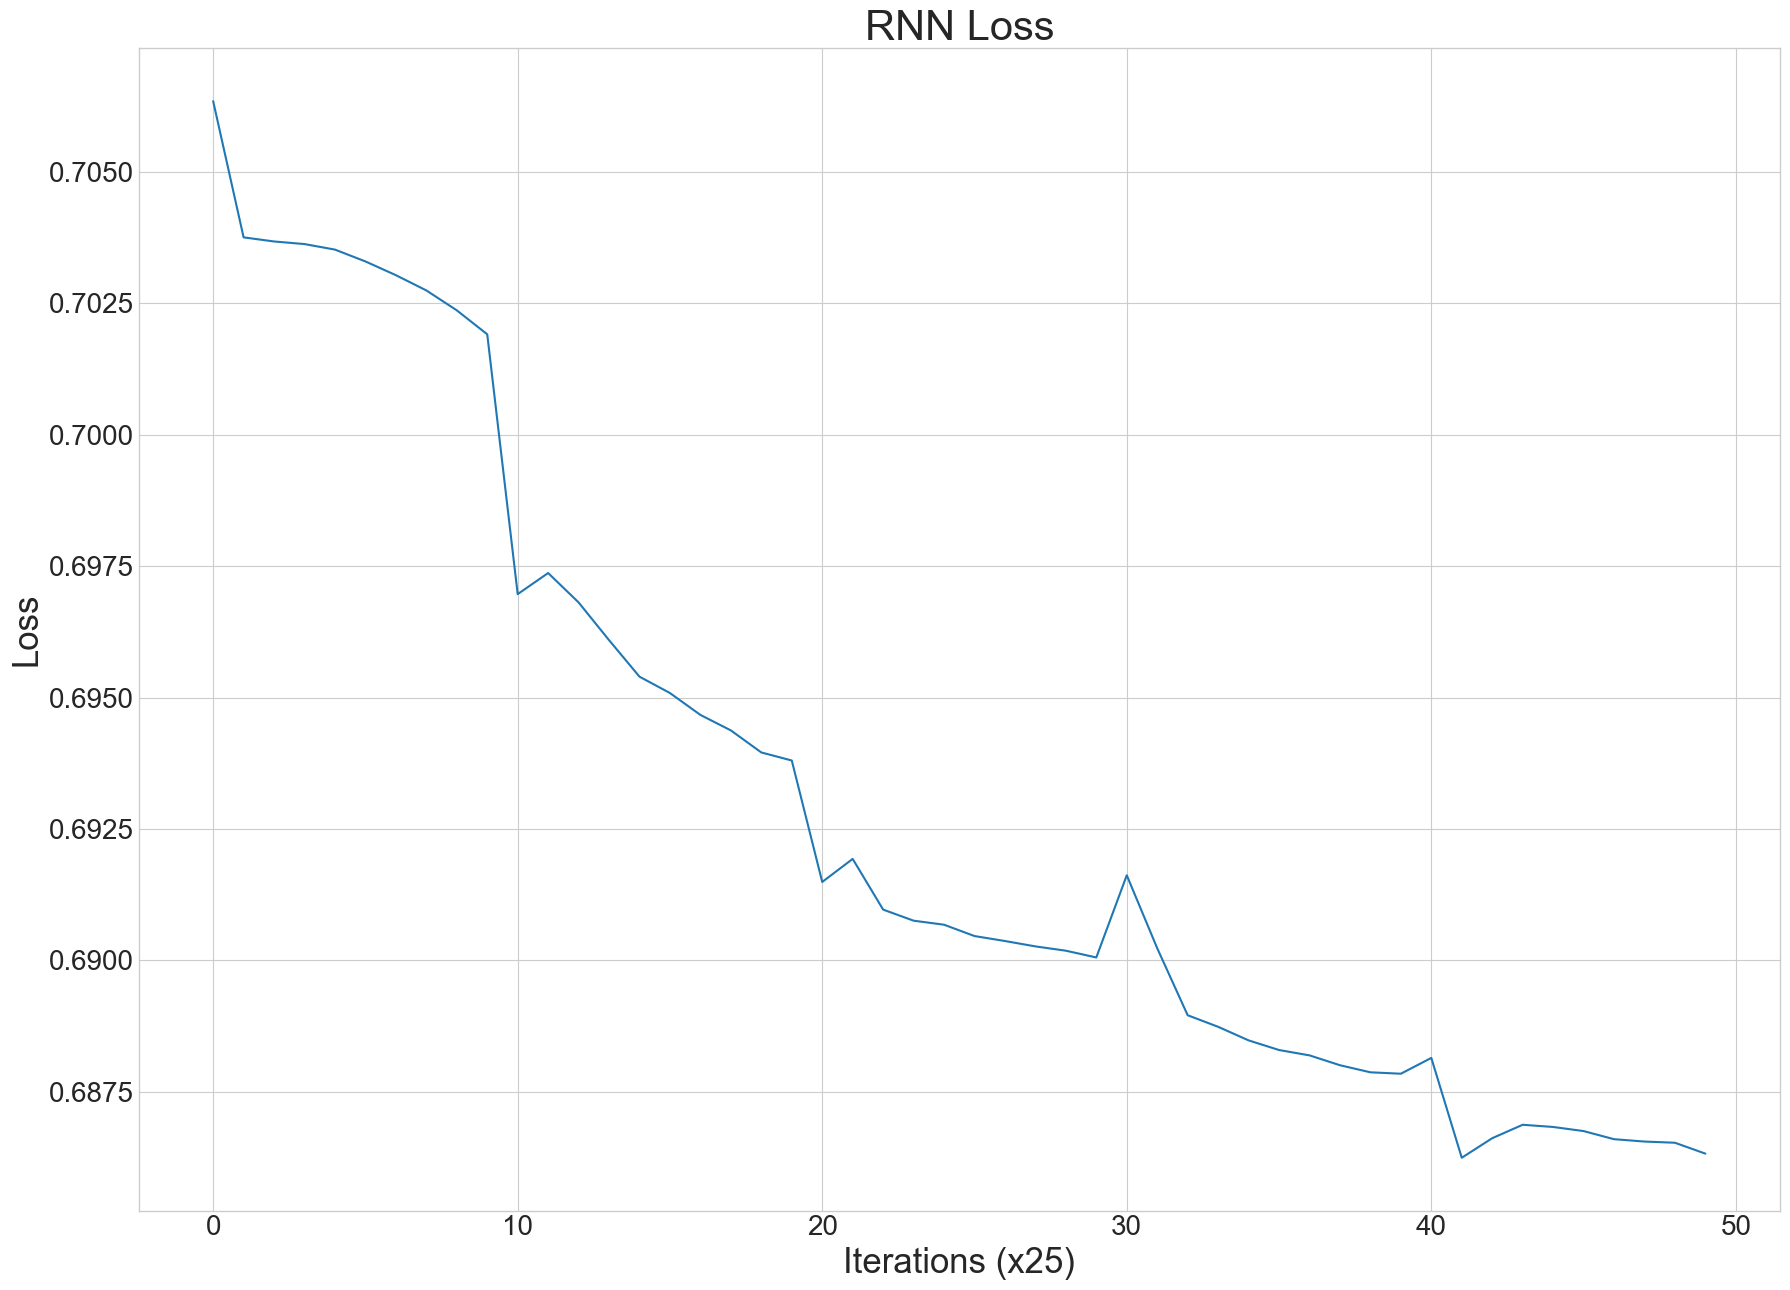

In [133]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(18,13))
plt.title("RNN Loss",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Iterations (x25)', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.plot(avg_losses)
plt.tight_layout()
# plt.savefig("RNN_3_loss")

In [123]:
avg_accuracy = sum(all_accuracy)/ len(all_accuracy)
avg_accuracy

0.4819940476190476

In [124]:
confusion

tensor([[363.,  75.,  88.,  14.,  44., 106.,  27.,  41.,  85.,  35.,  35.,  50.,
           1.],
        [ 22.,  83.,  64.,  40.,  62.,  42.,  47.,  35.,  48.,  91.,  60., 107.,
           2.],
        [ 14.,  21.,  28.,   5.,  17.,  22.,   3.,  10.,  11.,  10.,  14.,  12.,
           0.],
        [ 22.,  55.,  90., 686.,  53.,  72., 511., 171.,  52.,  68.,  22.,  78.,
           1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [ 13.,  52.,  59., 386.,  55.,  33., 688., 122.,  40.,  57.,  65.,  62.,
           3.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  6.,  12.,  12.,   6.,   4.,   6.,   9.,   1.,  15.,  10.,  11.,   3.,
           0.],
        [ 34.,  51.,  56.,  32.,  27.,  39.,  28.,  23.,  27., 147.,  40.,  42.,
           0.],
        [ 42., 161., 100.,  20

In [125]:
import math 
for i in range(len(fams)):
    for j in range(len(fams)):
        if confusion[i][j]==0:
            confusion[i][j]=0.0000001

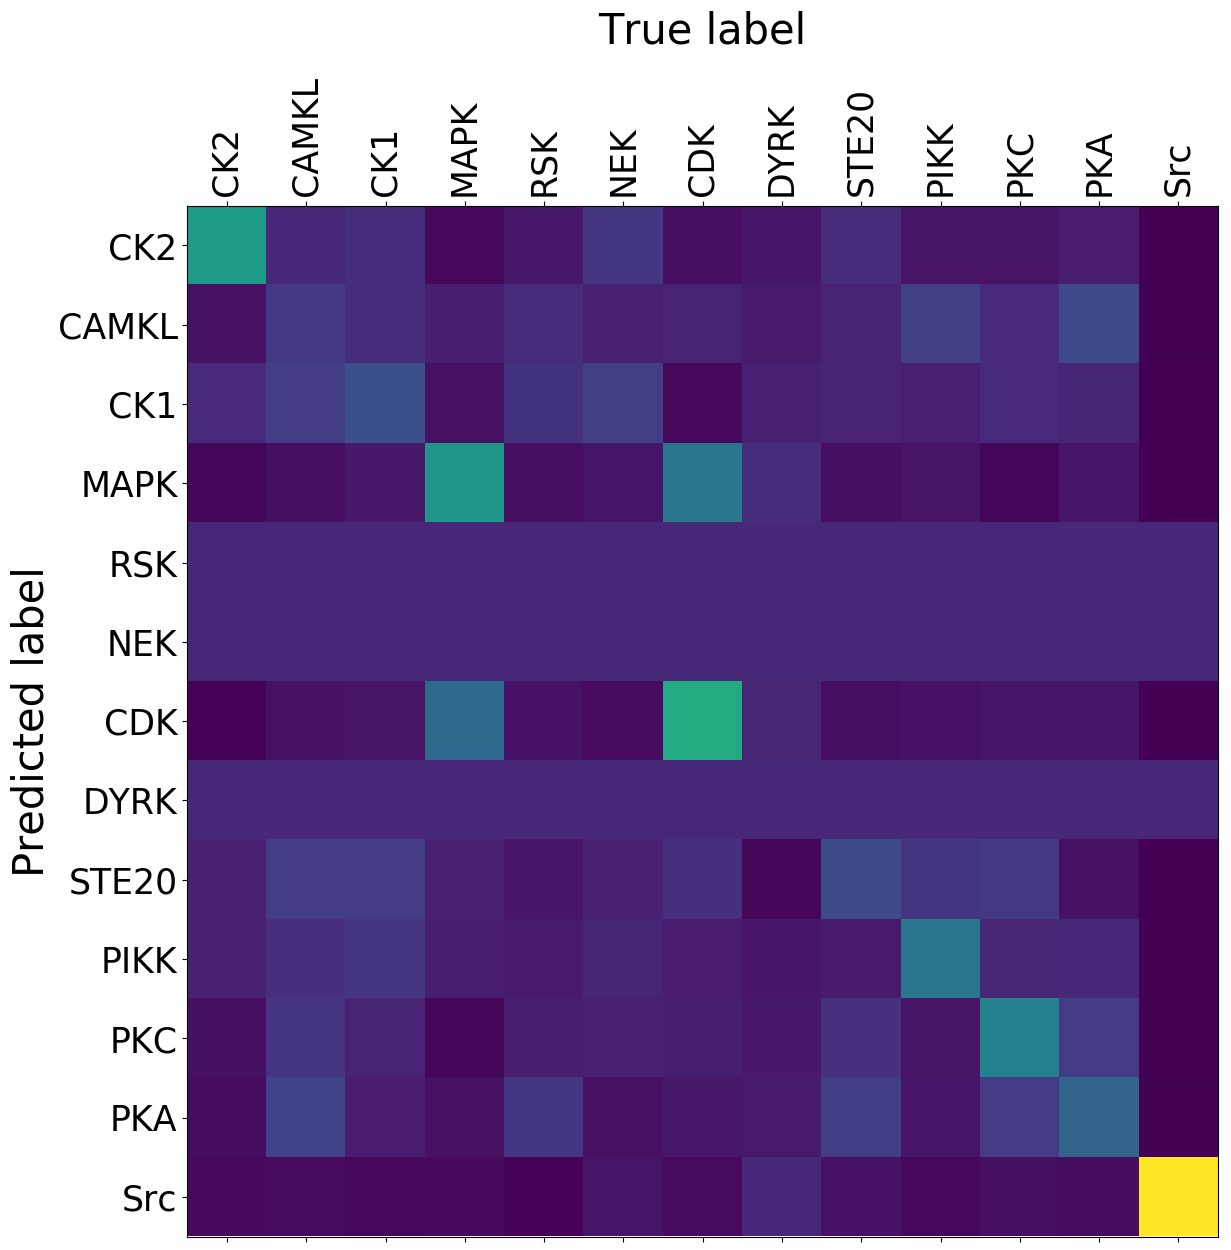

In [126]:
# Normalize by dividing every row by its sum
plt.style.use('default')
for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
# for i in range(len(fams)):
#     for j in range(len(fams)):
#         if math.isnan(confusion[i][j]) or confusion[i][j]==0:
#             confusion[i][j]=0

# Set up plot
fig = plt.figure(figsize=(12.5,12.5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)

# Set up axes
fs = [x for x in fams]
ax.set_xticklabels([''] + fs, rotation=90)
ax.set_yticklabels([''] + fs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# plt.title("RNN: Confusion matrix",fontsize=30,y=1.15)
plt.title("True label",fontsize=30,y=1.15)
plt.ylabel("Predicted label",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("poooo")


# sphinx_gallery_thumbnail_number = 2
plt.show()

In [127]:
y_test = []
for res in all_y_test:
    y_test.extend([x for x in res])

y_test = numpy.array(y_test)

y_score = []
for res in all_y_score:
    y_score.extend([x for x in res])

y_score = numpy.array(y_score)

In [128]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.41


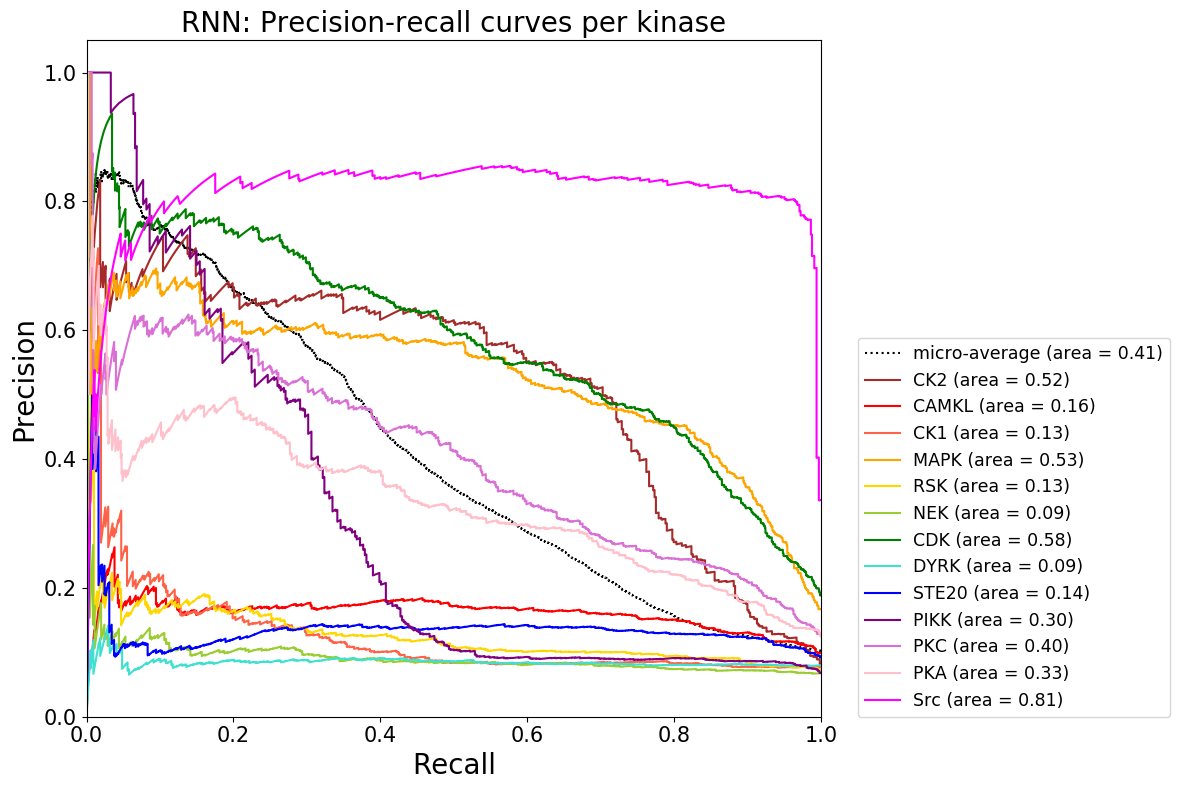

In [136]:
from itertools import cycle
import numpy as np
plt.style.use('default')

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
               'purple','pink','orchid']) 

colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

plt.figure(figsize=(12, 8))
f_scores = numpy.linspace(0.2, 0.8, num=4)
lines = []
labels = []

l, = plt.plot(recall["micro"], precision["micro"], color='black', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(fclass, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('RNN: Precision-recall curves per kinase',fontsize=20)
plt.legend(lines, labels, loc=(1.05, 0), fontsize=12.5)
plt.tight_layout()
plt.savefig("poo")

plt.show()

In [137]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

FAM_IDC = range(len(fams))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

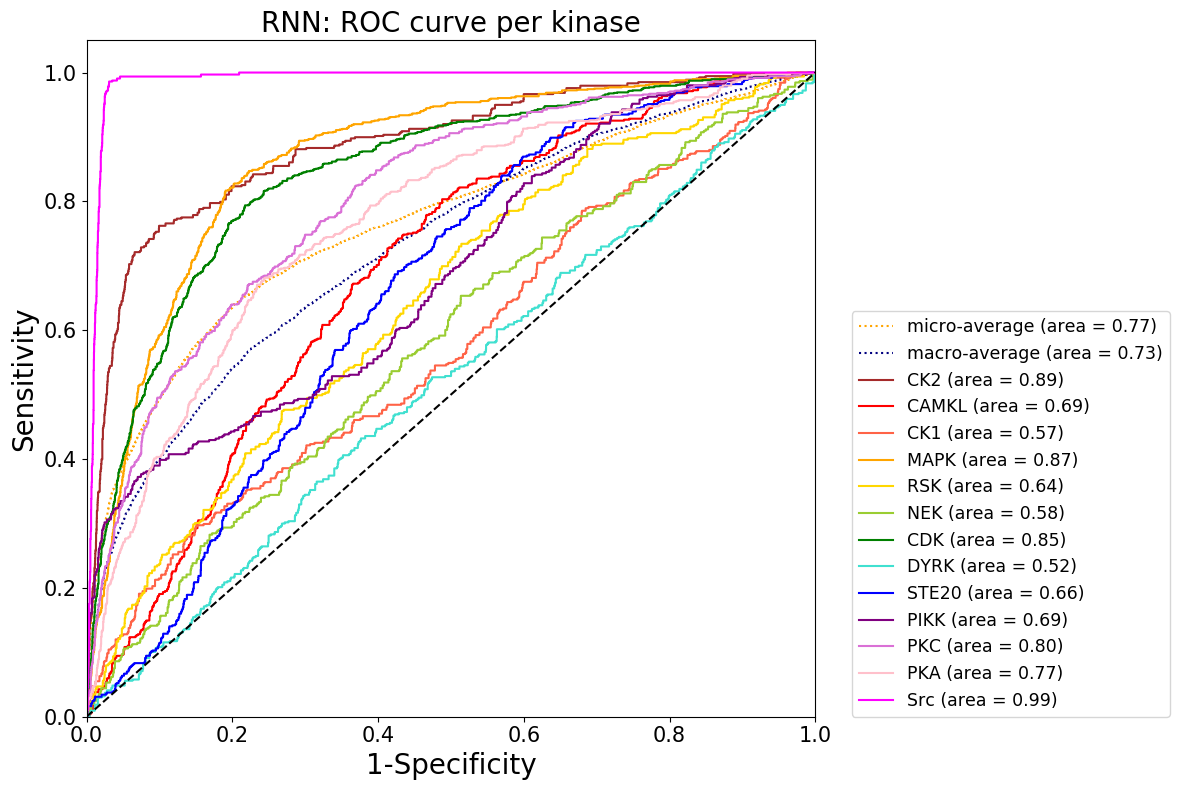

In [138]:
# Plot all ROC curves


lw = 1.5
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

for i, color in zip( (FAM_IDC), colors):
    fam = fams[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(fam, roc_auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('RNN: ROC curve per kinase',fontsize=20)
plt.legend(loc=(1.05, 0),fontsize=12.5)
plt.tight_layout()


# plt.savefig('fams_Stat_figs/RNN_ROC_select_testData_200OrMoreMotifs', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig("POOP")
plt.show()

In [139]:
confusion_numpy = confusion.detach().numpy()
FP = confusion_numpy.sum(axis=0) - np.diag(confusion_numpy)  
FN = confusion_numpy.sum(axis=1) - np.diag(confusion_numpy)
TP = np.diag(confusion_numpy)
TN = confusion_numpy.sum() - (FP + FN + TP)

print (FP)
print (FN)
print (TP)
print (TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print ("TPR:",numpy.mean(TPR))
print ("TNR:",numpy.mean(TNR)) 
print ("PPV:",numpy.mean(PPV)) 
print ("NPV:",numpy.mean(NPV)) 
print ("FPR:",numpy.mean(FPR)) 
print ("FNR:",numpy.mean(FNR)) 
print ("FDR:",numpy.mean(FDR)) 
print ("ACC:",numpy.mean(ACC)) 

[0.5609541  0.97956234 0.8612405  0.7522471  0.7191101  0.7815844
 0.8832679  0.7008566  0.81412727 0.72256434 0.8264664  0.8378505
 0.24246138]
[0.62344396 0.8819346  0.83233535 0.6353005  0.9230769  0.9230769
 0.5792049  0.9230769  0.84210527 0.73076934 0.69634545 0.7806801
 0.3109426 ]
[0.376556   0.11806543 0.16766468 0.36469963 0.07692308 0.07692308
 0.4207951  0.07692308 0.15789473 0.26923078 0.3036545  0.21931987
 0.6890574 ]
[11.439046  11.020437  11.13876   11.247753  11.2808895 11.218415
 11.116732  11.299143  11.185873  11.277435  11.173533  11.162149
 11.757539 ]
TPR: 0.25520822
TNR: 0.9379339
PPV: 0.25048202
NPV: 0.9379885
FPR: 0.06206598
FNR: 0.74479175
FDR: 0.749518
ACC: 0.8854167
